# Image reconstruction and generation

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from os import listdir
from random import shuffle
from matplotlib import pyplot as plt

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoding 3x64x64 image to latent vector of size 2048
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(1024, 2048, 2),
        )
        # decoding latent vector of size 2048 to 3x64x64 image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        """
        :param x: input image
        :return: reconstructed image
        """
        # encode image
        encoded = self.encoder(x)
        # decode image
        decoded = self.decoder(encoded)
        return decoded

In [3]:
# initialize device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# create model
model = Autoencoder().to(device)

# set loss criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [5]:
def imread(filename):
    """
    :param filename: input file name 
    :return: file data
    """
    return plt.imread(f'data/{filename}').transpose(2, 1, 0)

## Autoencoder training

In [6]:
def get_batches(batch_number=None, batch_size=32, test=False):
    """
    :param batch_number: batches count
    :param batch_size: size of one batch
    :param test: test sample if test == True else train sample
    :return: train or test sample
    """
    # read file names from 'faces' directory
    files = listdir('data')
    # get files in train or test range
    files = files[slice(int(len(files) * 0.8), len(files)) if test else slice(int(len(files) * 0.8))]
    shuffle(files)
    # normalize bath_number
    batch_number = min(batch_number or len(files) // batch_size, len(files) // batch_size)
    tests = []
    for _ in range(batch_number):
        # read {batch_size} images
        imgs = np.array([imread(files.pop()) for _ in range(batch_size)])
        # convert images to torch tensor
        tests.append(torch.tensor(imgs).to(device) / 255)
    return tests

In [7]:
# current best loss for filter
best = 1

In [8]:
num_epochs = 200
for epoch in range(num_epochs):
    # train model
    losses = []
    for img in get_batches(100):
        output = model(img)
        loss = criterion(output, img)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch:{epoch + 1}, Loss:{sum(losses) / len(losses)}')
    # test model
    losses = []
    for img in get_batches(test=True):
        output = model(img)
        loss = criterion(output, img)
        losses.append(loss.item())
    # update best
    loss = sum(losses) / len(losses)
    if loss < best:
        print('best:', loss)
        best = loss
        torch.save(model.state_dict(), 'best.pth')

Epoch:1, Loss:0.05814886562526226



KeyboardInterrupt



In [9]:
# load best model
model.load_state_dict(torch.load('best.pth'))

<All keys matched successfully>

## Image reconstruction

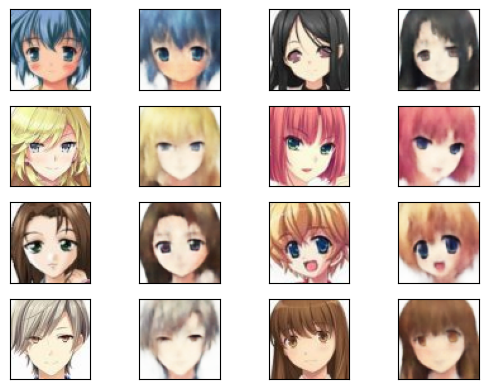

In [33]:
# show results
w, h = 2, 4
images = get_batches(1, 8, True)[0]
results = model(images).to('cpu').detach().numpy().transpose(0, 3, 2, 1)
images = images.to('cpu').detach().numpy().transpose(0, 3, 2, 1)

for x in range(w):
    for y in range(h):
        plt.subplot(h, w * 2, 2 * (x * h + y) + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[x * h + y])

        plt.subplot(h, w * 2, 2 * (x * h + y) + 2)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(results[x * h + y])

## Image generation

In [34]:
files = listdir('data')
shuffle(files)

# load random 1000 images
imgs = torch.tensor(np.array([imread(file) for file in files[:1000]])).to(device) / 255
# encode images to latent vectors
res = model.encoder(imgs).to('cpu').detach().numpy().T[0][0]
# find mean and standard deviation of latent vectors
mean = res.mean(axis=1)
std = res.std(axis=1)

# save mean and standard deviation of latent vectors
with open('distribution.txt', 'w') as f:
    f.write(' '.join(str(i) for i in mean))
    f.write('\n')
    f.write(' '.join(str(i) for i in std))

In [35]:
from scipy.stats import norm

# load mean and standard deviation
with open('distribution.txt') as f:
    mean = list(map(float, f.readline().split()))
    std = list(map(float, f.readline().split()))


def generate_input(n=1):
    """
    :param n: number of generated inputs
    :return: random noise based on normal distribution
    """
    input = np.array([norm.rvs(mean[i], std[i] * 3, n) for i in range(len(mean))], dtype=np.double).T
    return torch.tensor(input.reshape(n, 2048, 1, 1), dtype=torch.float32).to(device)

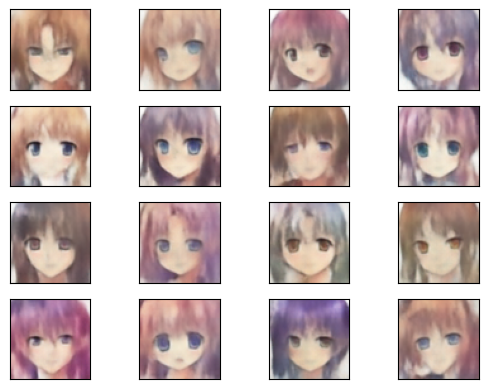

In [36]:
# show results
w, h = 4, 4
results = model.decoder(generate_input(w * h)).to('cpu').detach().numpy().transpose(0, 3, 2, 1)
for x in range(w):
    for y in range(h):
        plt.subplot(h, w, x * h + y + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(results[x * h + y])